# Imports

Need to have jate.py in your folder

In [1]:
%run jate.py #will import everything

# The code

## memory wiping

In [2]:
%reset_selective -f  omega_1, total_time, epsilon, max_iter, time_steps, dt

In [3]:
%reset_selective -f  Lin, T_s, I

## Building parts

### Building the things to be calculated only once

In [4]:
def maker(omega_1, H_0, H_1, T_s, Lin, d=2, gamma=0.1):
    r"""maker
    Makes all the things that remain constant throught the program, but are 
    repeatedly used.
    

    Parameters
    ----------
    omega_1 : float
              frequency corresponding to half of the difference between 
              energy levels of the qubit
              
    H_0     : Qobj
              Bare Hamiltonian 
              
    H_1     : Qobj
              Interaction Hamiltonian 
              
    T_s     : Qobj
              Unitary to be implemented in the Hilbert space
    
    Lin     : Qobj
              Linbladian operators

    d       : int
              Dimension of the matrix. Defaults to 2
    
    gamma   : float
              Damping constantof the Linbladian

    
    Returns
    -------
    
    ih0     : Qobj
              $I\otimes H_{0}$
              
    ih1     : Qobj
              $I\otimes H_{1}$

    h0ci    : Qobj
              $H_{0}^{*}\otimes I $

    h1ci    : Qobj
              $H_{1}^{*}\otimes I $

    T       : Qobj
              Target unitary transformed to the Liouville space

    linbladian : Qobj
                 The full lindbladian term as it appears on transformation to 
                 the Liouville space.
        
    """
    I = identity(d)
    L_I = tensor(I, I)
    ih0 = tensor(I, H_0) 
    ih1 = tensor(I, H_1) 
    h0ci = tensor(H_0.conj(), I) 
    h1ci = tensor(H_1.conj(), I)
    x_k = ih1 - h1ci
    term1 = tensor(Lin.trans(), Lin)
    term2 = tensor(I, ((Lin.dag())*(Lin)))
    term3 = tensor(((Lin.trans())*(Lin.conj())), I)
    lindbladian = 1j*(gamma)*(term1 - 0.5*(term2 + term3))
    T = tensor(T_s.trans(), T_s) # Transforming $T_{s}$ to liouville space
    
    
    return ih0, ih1, h0ci, h1ci, x_k, lindbladian, T, L_I

In [5]:
omega_1 = 0.5
H_0 = sigmaz() 
H_1 = sigmay()
T_s = sigmax() 
Lin = sigmaz()
ih0, ih1, h0ci, h1ci, x_k, lindbladian, T, L_I  = maker(omega_1,
                                                  H_0, H_1, T_s, 
                                                  Lin, d=2, gamma=0.1)

In [6]:
L_I

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]

### Building $A(t)$

In [7]:
def A(xi):
    r"""making $A(t)$"""
    A = ih0 - h0ci + xi*(ih1 - h1ci) + lindbladian
    return A

In [8]:
A(0.5)

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = False
Qobj data =
[[ 0.+0.j   0.-0.5j  0.-0.5j  0.+0.j ]
 [ 0.+0.5j -2.-0.2j  0.+0.j   0.-0.5j]
 [ 0.+0.5j  0.+0.j   2.-0.2j  0.-0.5j]
 [ 0.+0.j   0.+0.5j  0.+0.5j  0.+0.j ]]

### Building $L(t)$ and the Identity in the Liouville space

In [9]:
def L(xi, dt):
    r"""Making $L(t) from $A(t)$"""
    L = (-1j*A(xi)*dt).expm()
    return L

In [10]:
L(0.5, 0.001)

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = False
Qobj data =
[[ 9.99999750e-01+0.00000000e+00j -4.99949587e-04-4.99933130e-07j
  -4.99949587e-04+4.99933130e-07j  2.49983230e-07+0.00000000e+00j]
 [ 4.99949587e-04+4.99933130e-07j  9.99797770e-01+1.99959837e-03j
  -2.49966565e-07+0.00000000e+00j -4.99949587e-04-4.99933130e-07j]
 [ 4.99949587e-04-4.99933130e-07j -2.49966565e-07+0.00000000e+00j
   9.99797770e-01-1.99959837e-03j -4.99949587e-04+4.99933130e-07j]
 [ 2.49983230e-07+0.00000000e+00j  4.99949587e-04+4.99933130e-07j
   4.99949587e-04-4.99933130e-07j  9.99999750e-01+0.00000000e+00j]]

## Major functions

### Major functions 1

In [11]:
# building the function to optimize (optimizee)
def L_vec(xi_vec, dt):
    r"""Building the vector of differential $L(t)$"""
    L_vec = [L(xi, dt) for xi in xi_vec] 
    return L_vec

In [12]:
def fidelity_calc(A, B):
    r"""Making a generalised fidelity function"""
    first_part = (A - B).dag()
    second_part = (A - B)
    f_int = (first_part* second_part)
    f = f_int.tr()
    return f

In [13]:
def L_full_maker(xi_vec, dt):
    r"""Building the $L(t)$ for the total time $t$"""
    xi_vec_size = xi_vec.size # finding the size of xi
    L_full = L_I # Identity for the for loop of L
    L_v = L_vec(xi_vec, dt) # calling L_vec
    for i in range(xi_vec_size): # generating L_full
        L_full = L_full*L_v[xi_vec_size - 1 - i]
    return L_full

In [14]:
def F(xi_vec, dt):
    r"""Using the fidelity metric to find out the closeness between $T$
    and $L(t)$"""
    L_full = L_full_maker(xi_vec, dt)
    F = real(-fidelity_calc(T, L_full))   
    return F

### Testing major functions 1

In [15]:
fidelity_calc(sigmax(), sigmay())

4.0

In [16]:
fidelity_calc(sigmay(), sigmay())

0.0

In [17]:
xi_vec_test = array([1.0, 2.0])
xi_vec_test

array([1., 2.])

In [18]:
xi_vec_test.size

2

In [19]:
w_vec = [xi**2 for xi in xi_vec_test]
w_vec

[1.0, 4.0]

In [20]:
# F(xi_vec, dt)
F(xi_vec_test, 0.001)

-7.998400634487143

In [21]:
L_v = L_vec(xi_vec_test, 0.001)

In [22]:
L_v

[Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = False
 Qobj data =
 [[ 9.99999000e-01+0.00000000e+00j -9.99898674e-04-9.99866010e-07j
   -9.99898674e-04+9.99866010e-07j  9.99932670e-07+0.00000000e+00j]
  [ 9.99898674e-04+9.99866010e-07j  9.99797021e-01+1.99959737e-03j
   -9.99866010e-07+0.00000000e+00j -9.99898674e-04-9.99866010e-07j]
  [ 9.99898674e-04-9.99866010e-07j -9.99866010e-07+0.00000000e+00j
    9.99797021e-01-1.99959737e-03j -9.99898674e-04+9.99866010e-07j]
  [ 9.99932670e-07+0.00000000e+00j  9.99898674e-04+9.99866010e-07j
    9.99898674e-04-9.99866010e-07j  9.99999000e-01+0.00000000e+00j]],
 Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = False
 Qobj data =
 [[ 9.99996000e-01+0.00000000e+00j -1.99979335e-03-1.99973002e-06j
   -1.99979335e-03+1.99973002e-06j  3.99972668e-06+0.00000000e+00j]
  [ 1.99979335e-03+1.99973002e-06j  9.99794021e-01+1.99959337e-03j
   -3.99946004e-06+0.00000000e+00j -1.99979335e-03-1.99973

### Major Functions 2

In [23]:
def L_comma_k_maker(xi_vec, k, dt):
    r"""Making of the derivative of full $L(t)$ at time $t_{k}$"""
    N = xi_vec.size 
    # Determining the size of xi, and thus the time_steps indirectly.
    L_v = L_vec(xi_vec, dt)# Making of the full $L(t)$
    inner_part = L_I # Beginner for the for loop
    for i in range(N):
        if i == ( N - 1 - k ):
            # The step at which $X_{k}(t)$ has to be inserted 
            inner_part = inner_part*x_k*L_v[k - 1]
        else:
            # Usual multiplications of $L_{k}$
            inner_part = inner_part*L_v[N - 1 - i]
    l_comma_k = inner_part
    return l_comma_k
    

In [24]:
# L_comma_k_maker(xi_vec, k, dt)
L_comma_k_maker(xi_vec_test, 2, 0.001)

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = False
Qobj data =
[[ 9.99991001e-01+0.00000000e+00j -2.99927211e-03-6.99796565e-06j
  -2.99927211e-03+6.99796565e-06j  8.99882878e-06+0.00000000e+00j]
 [ 2.99947607e-03+4.99878084e-06j  9.99583086e-01+3.99836500e-03j
  -8.99749372e-06+5.99798035e-09j -2.99947607e-03-4.99878084e-06j]
 [ 2.99947607e-03-4.99878084e-06j -8.99749372e-06-5.99798035e-09j
   9.99583086e-01-3.99836500e-03j -2.99947607e-03+4.99878084e-06j]
 [ 8.99882878e-06+0.00000000e+00j  2.99927211e-03+6.99796565e-06j
   2.99927211e-03-6.99796565e-06j  9.99991001e-01+0.00000000e+00j]]

In [25]:
def updater(xi_vec, dt, epsilon):
    r"""Implementing the GRAPE update step"""
    xi_vec_size = xi_vec.size # finding the size of xi
    L_full = L_full_maker(xi_vec, dt)
    di = []
    for k in range(xi_vec_size):
        # Building the thing to be added to the old function
        L_comma_k = L_comma_k_maker(xi_vec, k, dt)
        differentiated = T - L_comma_k
        plain = T - L_full
        c = -differentiated.dag()*plain
        d = -plain.dag()*differentiated
        inside = c.tr() + d.tr()
        di.append(epsilon*inside)

    diff = array(di)
    xi_new_vec = xi_vec + diff
    return diff, xi_new_vec
    

In [26]:
#  updater(xi_vec, dt, epsilon)
updater(xi_vec_test, 0.001, 0.001)

(array([-0.008+0.j, -0.008+0.j]), array([0.992+0.j, 1.992+0.j]))

In [27]:
def terminator(max_iter, time_steps, total_time, epsilon):
    r"""Brief description of the function"""
    
    xi_initial =  1000*random_sample((time_steps,))
    dt = total_time/time_steps
    xi_diff, xi_new_vec = updater(xi_initial, dt, epsilon)
    
    for i in range(max_iter):
        if amax(xi_diff) < epsilon**2 :
            
            xi_final = xi_new_vec
            break
        else :
            xi_diff, xi_new_vec = updater(xi_new_vec, dt, epsilon)
            print(i)
            print(amax(xi_diff))
            
        
    xi_final = xi_new_vec    
    return xi_final

In [28]:
def rosen(x):
    """The Rosenbrock function"""
    return sum(100.0*(x[1:]-x[:-1]**2.0)**2.0 + (1-x[:-1])**2.0)
x0 = np.array([1.3, 0.7, 0.8, 1.9, 1.2])
res = optimize.minimize(rosen, x0, method='nelder-mead',
                        options={'xtol': 1e-8, 'disp': True})
print(res.x)

NameError: name 'np' is not defined

In [34]:
total_time = 10*pi/omega_1
time_steps = 200
dt = total_time/time_steps
def f_nel(xi_vec):
    return F(xi_vec, dt)

x0 = 1000*random_sample((time_steps,))
from scipy import optimize
res = optimize.minimize(f_nel, x0, method='nelder-mead',
                        options={'xtol': 1e-8, 'disp': True})
print(res.x)

[1.11396161e+02 8.86458639e+01 7.72033608e+02 8.60933949e+02
 1.84041027e+02 3.74463817e+02 3.70327492e+02 9.69450114e+02
 3.51638466e+02 2.41058398e+02 1.25272504e+02 1.96450332e+02
 2.31527805e+02 4.76111664e+02 3.18768711e+02 3.53553692e+01
 9.29939582e+02 5.13615192e+02 6.95826690e+02 8.21104591e+02
 9.67587509e+02 3.73412337e+02 6.99273605e+02 9.12984225e+02
 4.51476618e+02 3.18270521e+02 9.83045796e+02 2.03768167e+02
 3.60676595e+02 9.90254848e+02 5.90011125e+02 7.14972298e+02
 2.14408925e+02 4.73749382e+02 5.69968571e+02 5.54859319e+02
 7.84189333e+02 1.62988397e+02 6.20847469e+01 2.90771738e+02
 5.48326363e+02 7.27990233e+02 2.65720305e+02 6.25281685e+02
 1.71491637e+02 5.59979383e+02 5.77146549e+02 9.20747961e+02
 9.25591081e+02 2.76251768e+02 8.99186223e+01 4.08390217e+02
 2.41910746e+02 8.60604508e+02 8.38228974e+02 7.37234998e+02
 5.48695897e+02 7.00915937e+02 9.02990128e+02 9.59440665e+01
 9.07750906e+02 9.87999799e+02 9.34226138e+02 9.62280725e+02
 5.18499589e+02 3.430591

In [ ]:
res.success

In [ ]:
res.nit

In [ ]:
res.fev

In [ ]:
res.status

In [ ]:
res.message

In [ ]:
F(res.x, dt)

In [ ]:
hinton(T)

In [ ]:
hinton(L_full_maker(res.x, dt))

In [ ]:
L_full_maker(res.x, dt)

# Running stuff

### Try1

In [114]:
total_time = pi/omega_1
epsilon = 10**(-6)
max_iter = 10#10**4#1000#100#50#20
time_steps = 20
dt = total_time/time_steps

(<Figure size 576x432 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1163cf6a0>)

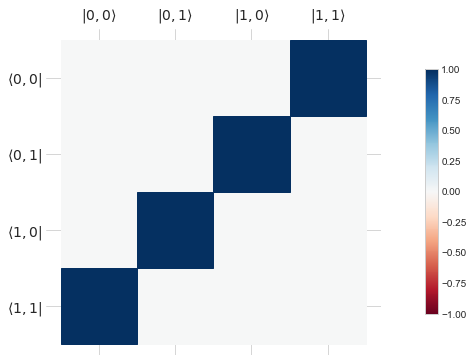

In [8]:
hinton(T)

In [115]:
xi_opt = terminator(max_iter, time_steps, total_time, epsilon)
xi_opt

array([253.12809151+0.j, 843.88141913+0.j, 670.69241692+0.j,
       924.100077  +0.j, 342.69688787+0.j, 123.45758492+0.j,
       879.26165155+0.j, 520.4459173 +0.j, 339.72130347+0.j,
       984.45194508+0.j,  64.74984188+0.j,  81.10046078+0.j,
         2.82873766+0.j, 265.22266621+0.j, 207.7809171 +0.j,
       834.24591251+0.j, 964.13437576+0.j, 875.54876982+0.j,
       129.61146026+0.j, 466.77550287+0.j])

In [117]:
F(xi_opt, dt)

-3.9789212334927573

In [118]:
max_iter

10

In [120]:
T

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [1. 0. 0. 0.]]

In [122]:
L_full_maker(xi_opt, dt)

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = False
Qobj data =
[[ 0.28233594+0.j         -0.16005333-0.00893544j -0.16005333+0.00893544j
   0.71766406+0.j        ]
 [ 0.14342862-0.05006893j -0.05447685+0.00321831j -0.30317032+0.17678044j
  -0.14342862+0.05006893j]
 [ 0.14342862+0.05006893j -0.30317032-0.17678044j -0.05447685-0.00321831j
  -0.14342862-0.05006893j]
 [ 0.71766406+0.j          0.16005333+0.00893544j  0.16005333-0.00893544j
   0.28233594+0.j        ]]

(<Figure size 576x432 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1a1b792400>)

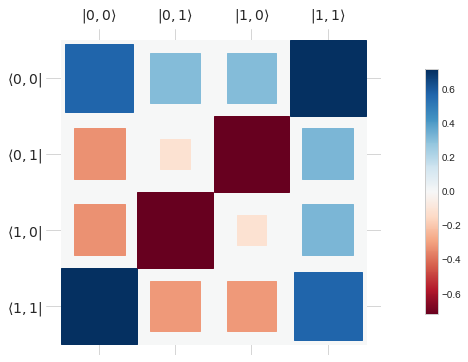

In [123]:
hinton(L_full_maker(xi_opt, dt))

# Next chapter

## memory clear (uses regex, so be careful)

In [7]:
%reset_selective -f var1, var2  # replace var1, var2 with your defined ones

## sub topic 2

In [8]:
cnot()

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]]

## sub topic 3

### sub sub topic 1